## 2. Agrupamiento

En este punto se busca analizar si es posible agrupar los datos en función de algún criterio. Para esta tarea se utilizará el algoritmo K-Means para generar clusters con los datos. 

In [1]:
import sklearn as sklearn
from sklearn.cluster import KMeans

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy.stats as st

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from matplotlib import patches

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None


df_preprocesado = pd.read_csv('df_preprocesado.csv')

In [3]:
dataset_array = df_preprocesado.values
print(dataset_array.dtype)
print(dataset_array)

object
[['2021-09-09' -34.6373187 -58.361124 ... 55.0 82900.0
  'VENTA TRES AMBIENTES LA BOCA PISO ALTO']
 ['2021-09-09' -34.6286465 -58.3618713 ... 70.0 99000.0
  'Departamento - 4 Ambientes - Catalinas Sur']
 ['2021-09-09' -34.6100272 -58.4019341 ... 104.0 146000.0
  'Venta departamento 4 ambientes Once']
 ...
 ['2021-01-05' -34.614175 -58.4790625 ... 30.0 75500.0
  'VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA //// APTO CREDITO HIPOTECARIO']
 ['2021-01-05' -34.614175 -58.4790625 ... 31.0 74500.0
  'VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF C/ BALCÓN Vta Ata, PISO ALTO. BAJAS EXP. // APTO CRED.']
 ['2021-01-05' -34.59979 -58.373411 ... 84.0 135000.0
  'VENTA DEPTO 2 1/2 AMBIENTES - CENTRO']]


Como se observa y habíamos visto anteriormente, se tienen bastantes variables cualitativas por ende tomamos solo aquellas que son cuantitativas para poder utilizar el algoritmo de K means

### Analisis de tendencia a clustering

In [4]:
from pyclustertend import hopkins
ds_properati_numeric = df_preprocesado.select_dtypes(include=np.number)
ds_properati_numeric.head()


latitud   longitud  property_rooms  property_bedrooms  \
0 -34.637319 -58.361124             3.0                2.0   
1 -34.628647 -58.361871             4.0                3.0   
2 -34.610027 -58.401934             4.0                2.0   
3 -34.631621 -58.416825             4.0                2.0   
4 -34.623886 -58.412746             2.0                1.0   

   property_surface_total  property_surface_covered  property_price  
0               58.000000                      55.0         82900.0  
1               70.000000                      70.0         99000.0  
2              124.408727                     104.0        146000.0  
3               97.673080                      73.0        250000.0  
4               61.000000                      46.0        100000.0

Una vez que ya tenemos nuestro Dataset lo normalizamos usando Min Max Scaler para que las variables cuantitativas que poseen distinta unidad de medida puedan ser facilmente comparables teniendo un mismo peso.

In [5]:
from sklearn.preprocessing import scale, MinMaxScaler

scaler = MinMaxScaler()
ds_properati_numeric_escalado = scaler.fit_transform(ds_properati_numeric)

In [6]:
hopkins(ds_properati_numeric_escalado,ds_properati_numeric_escalado.shape[0])

0.04230710509220231

Podemos ver que hay una alta tendencia a formar clusters, cabe aclarar que esto difiere con lo visto teoreticamente, pero se concluye dado ya que segun la [documentación](https://pyclustertend.readthedocs.io/en/latest/pyclustertend.html#module-pyclustertend.hopkins) cuando `hopkins()` resulta un numero tendiendo a 0 significa que hay una alta tendencia a la clusterizacion.

### Estimación de cantidad de clusters a formar y evaluación por Silhouette

Una vez calculada la tendecia a formar clusters usamos la regla del codo para poder determinar el numero de clusters

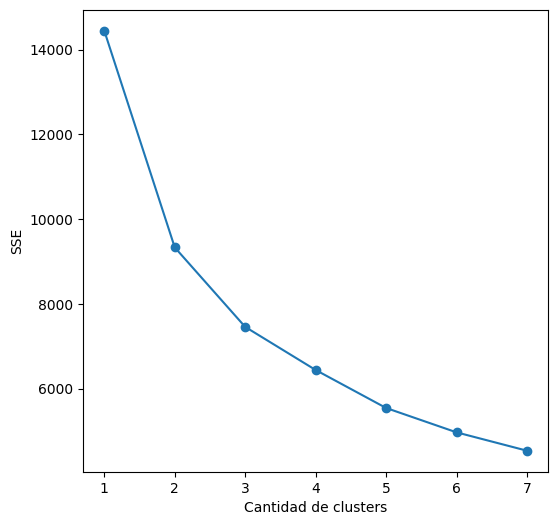

In [7]:
# Corro el algoritmo con K entre 2 y 8 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 8))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(ds_properati_numeric_escalado)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

- Observando el grafico podemos concluir que se podrían formar de 2 a 4 clusters.
- Para verificar esto utilizamos el algoritmo de Sillouette

In [8]:
from sklearn.metrics import silhouette_score

list_k = range(2, 5)

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    preds = clusterer.fit_predict(ds_properati_numeric_escalado)

    score = silhouette_score (ds_properati_numeric_escalado, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters =2 silhouette score is 0.36375512695388507
For n_clusters =3 silhouette score is 0.25762517772182575
For n_clusters =4 silhouette score is 0.24809350323030352


El score de silhouette resulta mejor para 2 que para 3,4,5 clusters, con lo cual decidimos continuar con 2.

Procedemos a visualizar dicho score graficamente

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


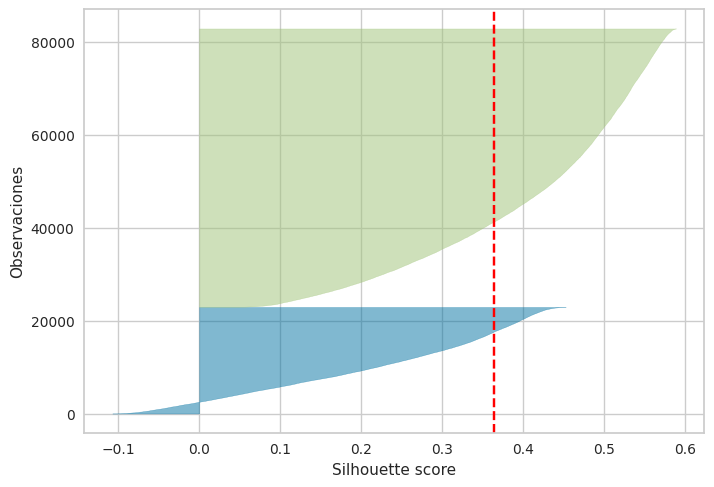

In [9]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(2, random_state=0)

# Visualizamos el gráfico de silueta para 2 clusters
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(ds_properati_numeric_escalado)
plt.xlabel("Silhouette score")
plt.ylabel("Observaciones")
plt.show()

In [10]:
kmeans = KMeans(n_clusters=2, random_state=0)  #Creamos un objeto de la clase KMeans para realizar el agrupamiento

kmeans.fit(ds_properati_numeric_escalado) #Entrenamos el algoritmo para que aprenda cómo agrupar

y_kmeans = kmeans.predict(ds_properati_numeric_escalado) #Obtenemos los resultados de aplicar el modelo para agrupar en el dataset

En principio se procede con la clusterización anterior (resultando en dos clusters). Posteriormente se analizará si se utilizan tres.

Se obtienen entonces los 2 grupos formados

In [11]:
group1 = ds_properati_numeric[y_kmeans == 0]
group2 = ds_properati_numeric[y_kmeans == 1]

In [12]:
group1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22931 entries, 2 to 82850
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   22931 non-null  float64
 1   longitud                  22931 non-null  float64
 2   property_rooms            22931 non-null  float64
 3   property_bedrooms         22931 non-null  float64
 4   property_surface_total    22931 non-null  float64
 5   property_surface_covered  22931 non-null  float64
 6   property_price            22931 non-null  float64
dtypes: float64(7)
memory usage: 1.4 MB


In [13]:
group2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59924 entries, 0 to 82854
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   59924 non-null  float64
 1   longitud                  59924 non-null  float64
 2   property_rooms            59924 non-null  float64
 3   property_bedrooms         59924 non-null  float64
 4   property_surface_total    59924 non-null  float64
 5   property_surface_covered  59924 non-null  float64
 6   property_price            59924 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


### Grafico geografico sobre los 2 clusters obtenidos

Se realiza una primera visualización de los grupos obtenidos sobre el mapa de CABA

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


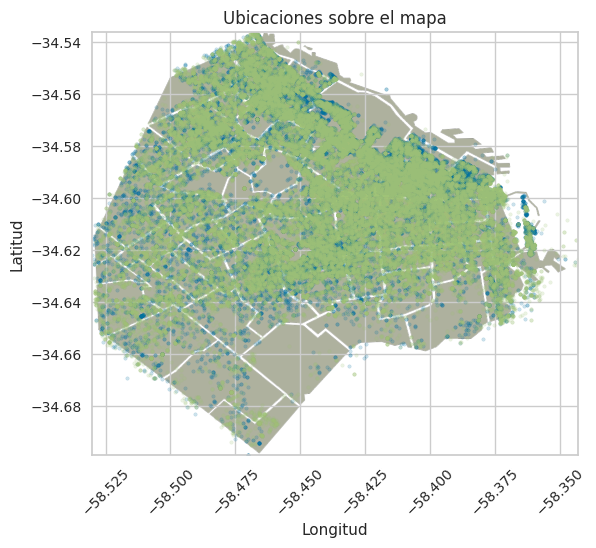

In [14]:
# calculamos limites de la imagen
lat_min = ds_properati_numeric['latitud'].min()
lat_max = ds_properati_numeric['latitud'].max()
long_min = ds_properati_numeric['longitud'].min()
long_max = ds_properati_numeric['longitud'].max()

# seteamos limites del grafico
plt.xlim([long_min, long_max])
plt.ylim([lat_min,lat_max])

# cargamos imagen y ajustamos su tamaño
im = plt.imread("mapa.png")
plt.imshow(im, extent=[long_min-0.0075, long_max+0.0025, lat_min, lat_max])

# graficamos los puntos
plt.scatter(x=group1.longitud,y=group1.latitud ,s=25 ,cmap='viridis', alpha=0.2, marker='.')
plt.scatter(x=group2.longitud,y=group2.latitud ,s=25 ,cmap='viridis', alpha=0.2, marker='.')

plt.title('Ubicaciones sobre el mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.tick_params(axis='x', labelrotation = 45)
plt.show()

### Analisis y visualizacion de los 3 clusters formados

Primero analizamos las visualizaciones de distintas combinaciones de variables 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


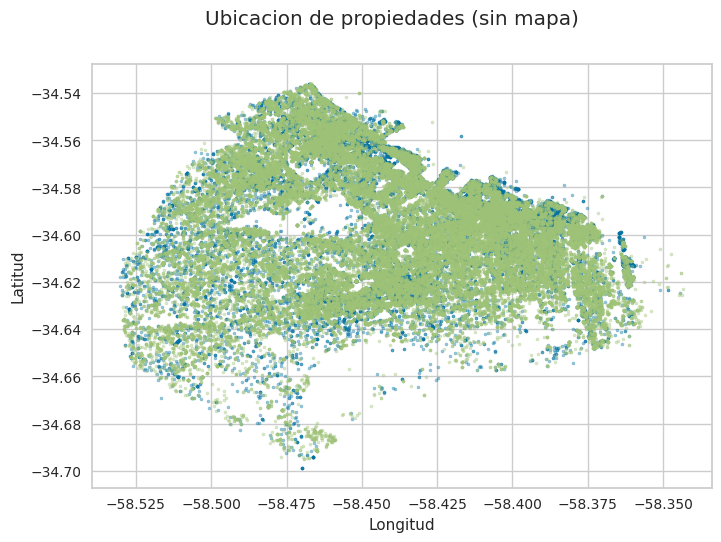

In [15]:
fig, ax = plt.subplots(1)
fig.suptitle('Ubicacion de propiedades (sin mapa)')

plt.scatter(x=group1.longitud, y=group1.latitud,s=5 ,cmap='viridis', alpha=0.4)
plt.scatter(x=group2.longitud, y=group2.latitud,s=5 ,cmap='viridis', alpha=0.4)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

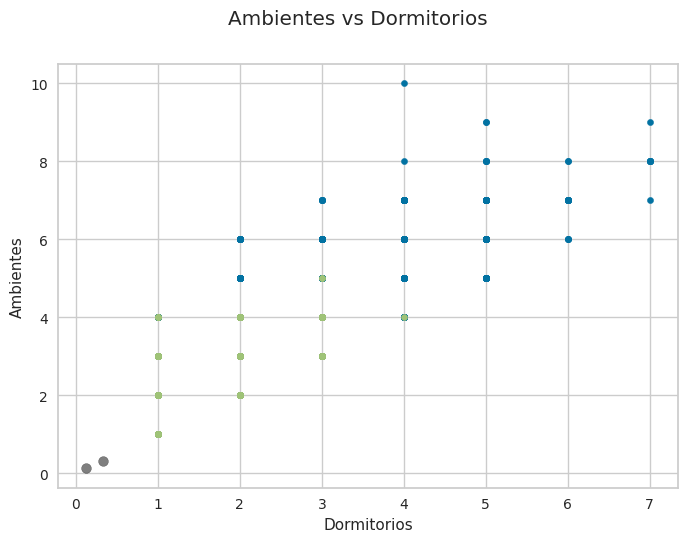

In [16]:
centers = kmeans.cluster_centers_
fig, ax = plt.subplots(1)
fig.suptitle('Ambientes vs Dormitorios')
plt.scatter(x=group1.property_bedrooms, y=group1.property_rooms,s=20 ,cmap='viridis')
plt.scatter(x=group2.property_bedrooms, y=group2.property_rooms,s=20 ,cmap='viridis')
plt.scatter(centers[:, 2], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel("Dormitorios")
plt.ylabel("Ambientes")
plt.show()

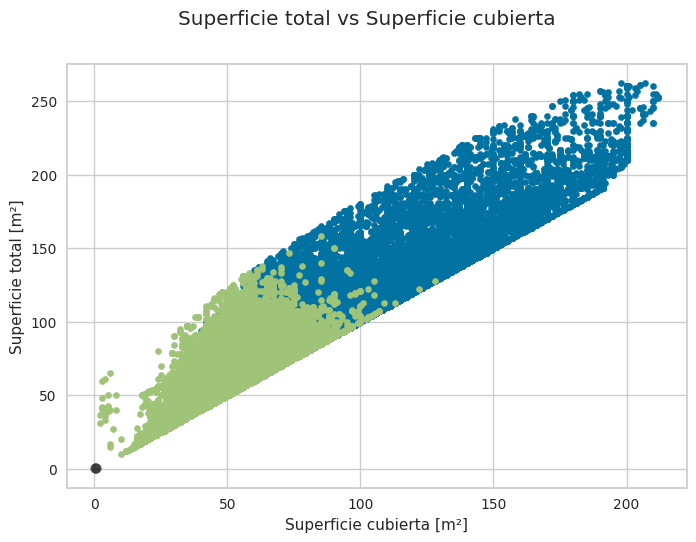

In [17]:
fig, ax = plt.subplots(1)
fig.suptitle('Superficie total vs Superficie cubierta')
plt.scatter(x=group1.property_surface_covered, y=group1.property_surface_total,s=20 ,cmap='viridis')
plt.scatter(x=group2.property_surface_covered, y=group2.property_surface_total,s=20 ,cmap='viridis')
plt.scatter(centers[:, 4], centers[:, 4], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel("Superficie cubierta [m²]")
plt.ylabel("Superficie total [m²]")
plt.show()

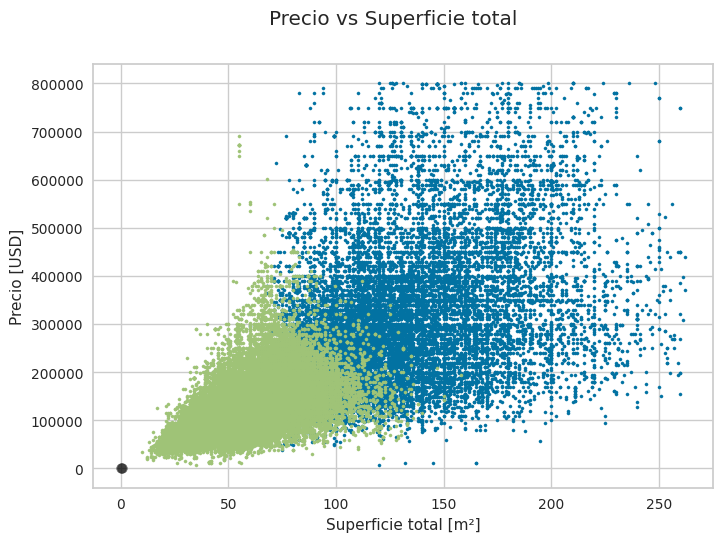

In [18]:
fig, ax = plt.subplots(1)
fig.suptitle('Precio vs Superficie total')
plt.scatter(group1.property_surface_total, group1.property_price,s=5 ,cmap='viridis')
plt.scatter(group2.property_surface_total, group2.property_price,s=5 ,cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 4], centers[:, 4], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel("Superficie total [m²]")
plt.ylabel("Precio [USD]")
plt.show()

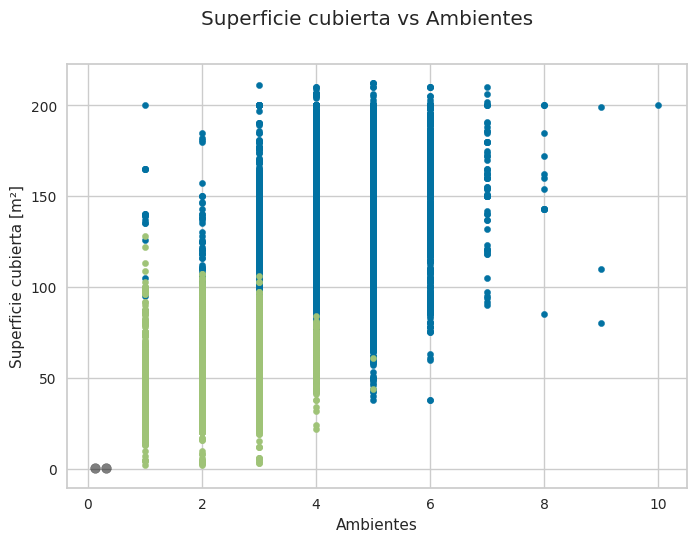

In [19]:
fig, ax = plt.subplots(1)
fig.suptitle('Superficie cubierta vs Ambientes')
plt.scatter(group1.property_rooms, group1.property_surface_covered,s=20 ,cmap='viridis')
plt.scatter(group2.property_rooms, group2.property_surface_covered,s=20 ,cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel("Ambientes")
plt.ylabel("Superficie cubierta [m²]")
plt.show()

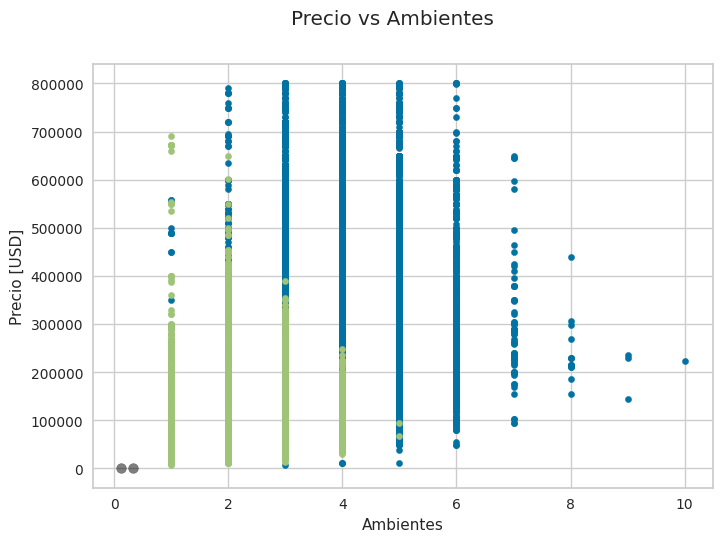

In [20]:
fig, ax = plt.subplots(1)
fig.suptitle('Precio vs Ambientes')
plt.scatter(group1.property_rooms, group1.property_price,s=20,cmap='viridis')
plt.scatter(group2.property_rooms, group2.property_price,s=20,cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel("Ambientes")
plt.ylabel("Precio [USD]")
plt.show()

En principio se observa que no se puede llegar a concluir mucha información a partir de las visualizaciones en dos dimensiones, dado que los clusters se formaron teniendo en cuenta a 7 variables distintas.
Lo único que se podría interpretar es una posible clusterización hecha en conjunto a partir de:
- La ubicación de las propiedades.
- Una especie de caracterización compuesta a partir de la correlacion de precio, cantidad de ambientes/dormitorios y superficies total/cubierta.  

Para verificar de mejor manera se propone la realización de graficos tridimensionales con las siguientes comparaciones de variables:
- Latitud vs Longitud vs Precio
- Latitud vs Longitud vs Superficie total
- Latitud vs Longitud vs Ambientes
- Precio vs Superficie total vs Ambientes


- **Latitud vs Longitud vs Precio:**

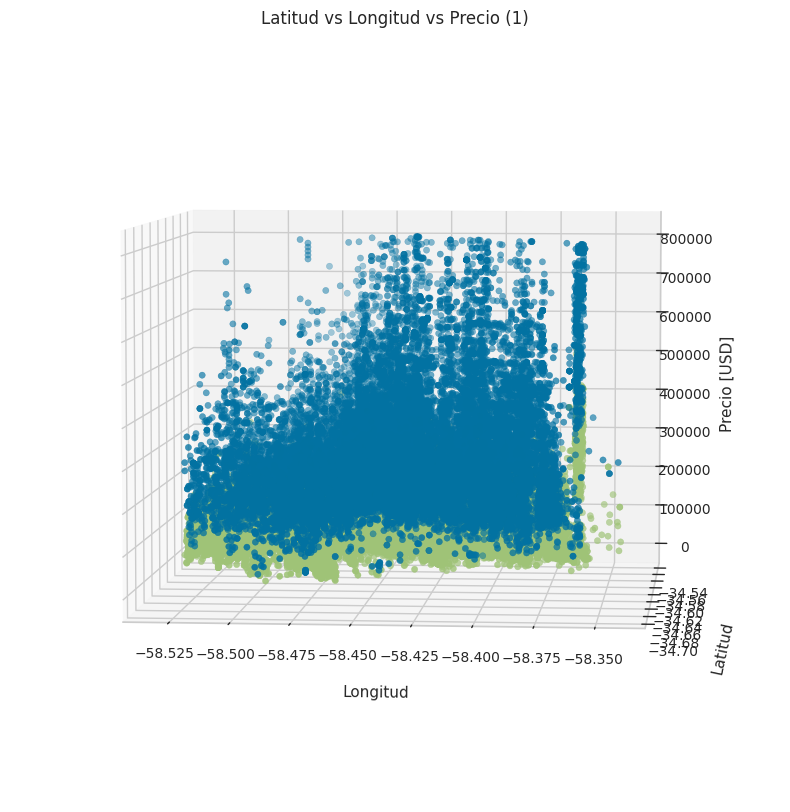

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_price)
ax.scatter(group2.longitud, group2.latitud,group2.property_price)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Precio [USD]", labelpad=20)
ax.elev = 5  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Precio (1)")
plt.show()

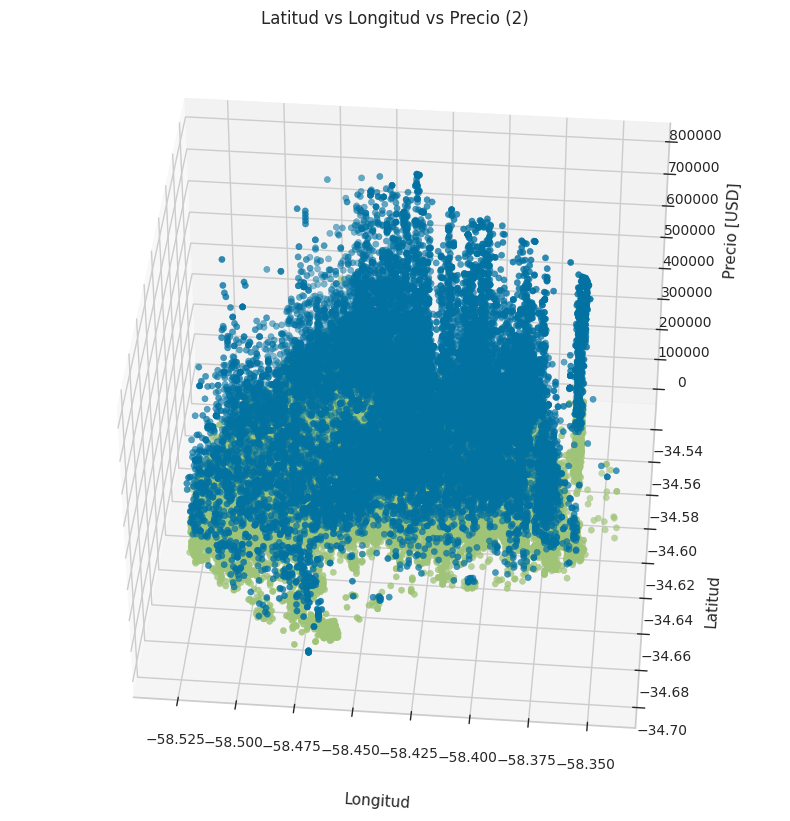

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_price)
ax.scatter(group2.longitud, group2.latitud,group2.property_price)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Precio [USD]", labelpad=20)
ax.elev = 40  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Precio (2)")
plt.show()

- **Latitud vs Longitud vs Superficie total:**

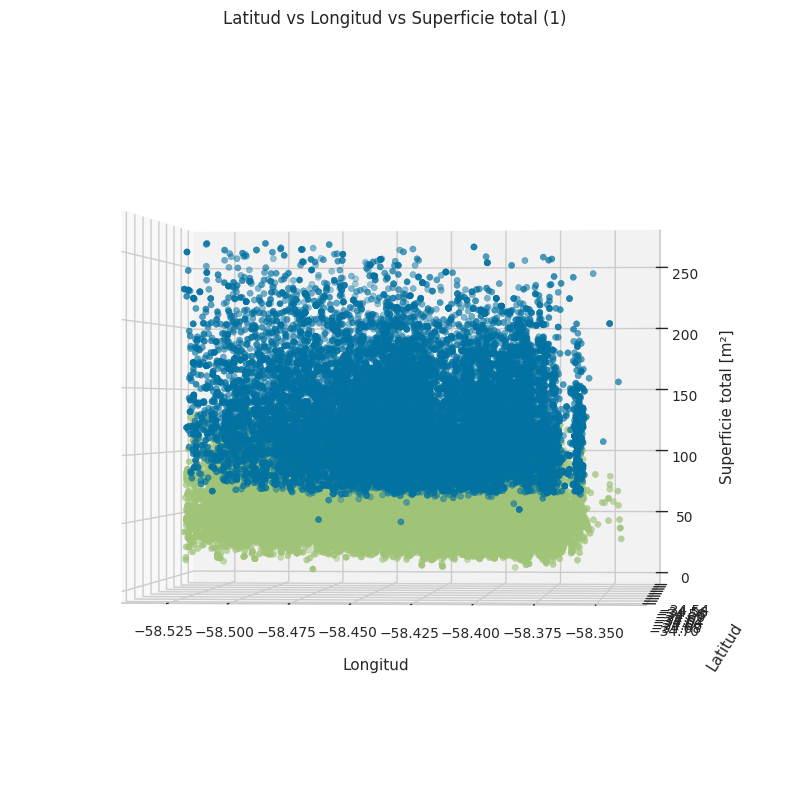

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_surface_total)
ax.scatter(group2.longitud, group2.latitud,group2.property_surface_total)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Superficie total [m²]", labelpad=20)
ax.elev = 0  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Superficie total (1)")
plt.show()

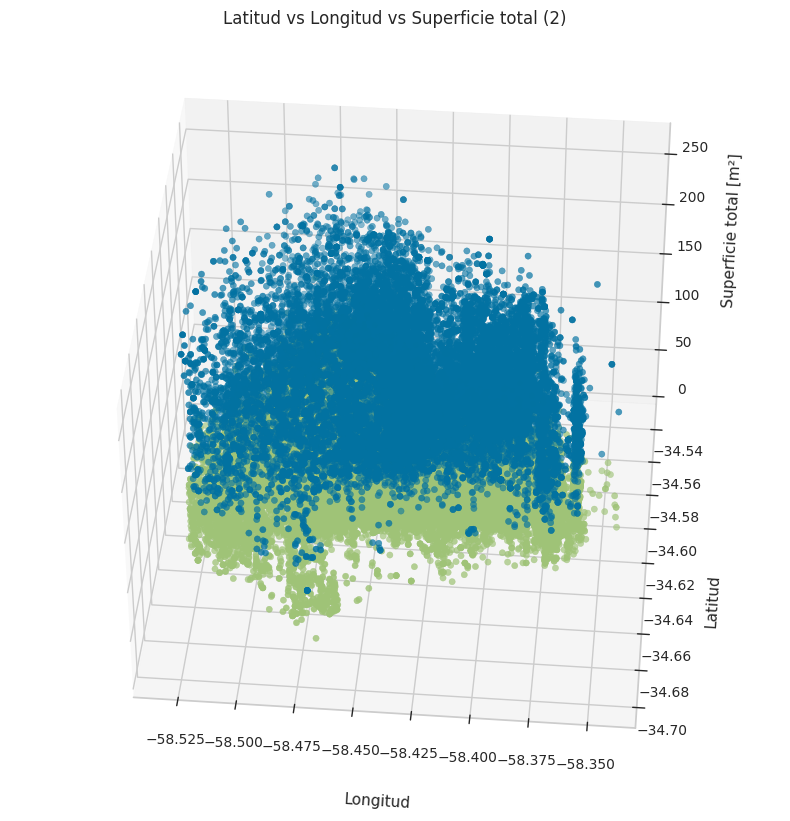

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_surface_total)
ax.scatter(group2.longitud, group2.latitud,group2.property_surface_total)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Superficie total [m²]", labelpad=20)
ax.elev = 40  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Superficie total (2)")
plt.show()

- **Latitud vs Longitud vs Ambientes:**

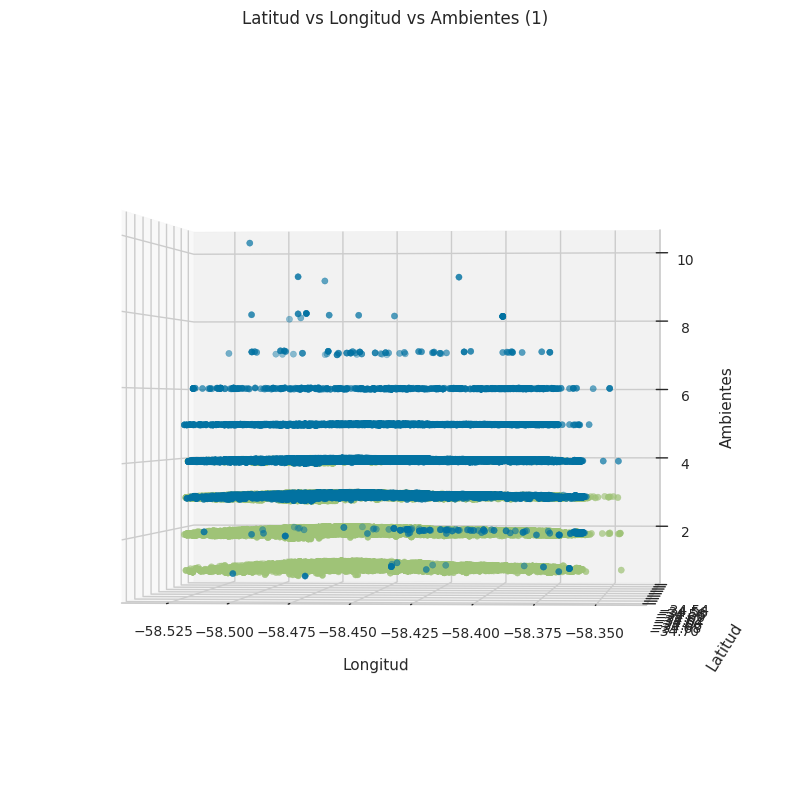

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_rooms)
ax.scatter(group2.longitud, group2.latitud,group2.property_rooms)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Ambientes", labelpad=20)
ax.elev = 0  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Ambientes (1)")
plt.show()

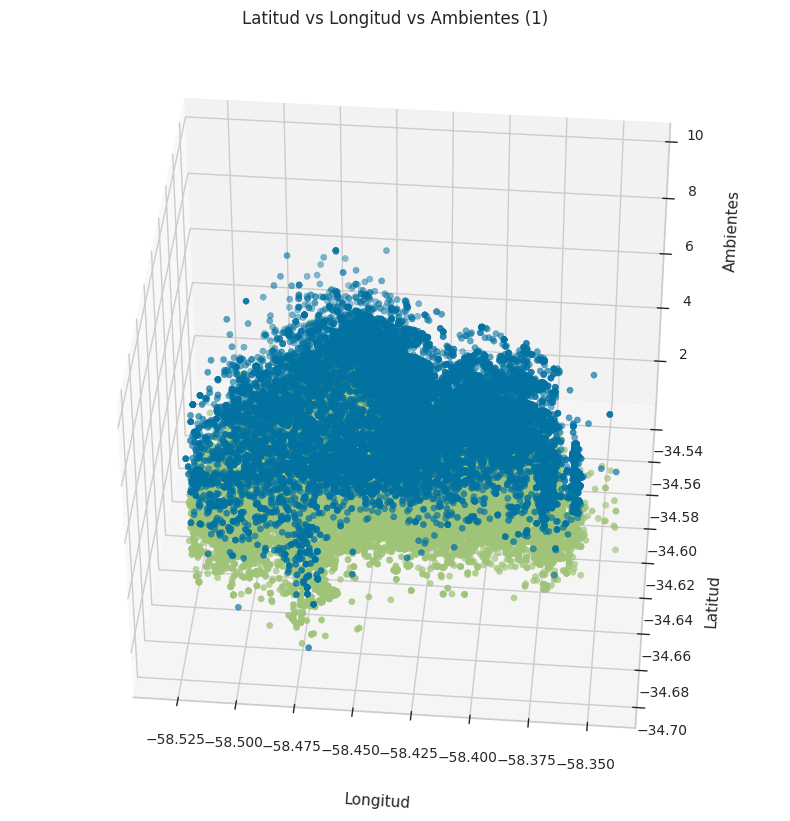

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_rooms)
ax.scatter(group2.longitud, group2.latitud,group2.property_rooms)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Ambientes", labelpad=20)
ax.elev = 40  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Ambientes (1)")
plt.show()

- **Precio vs Superficie total vs Ambientes:**

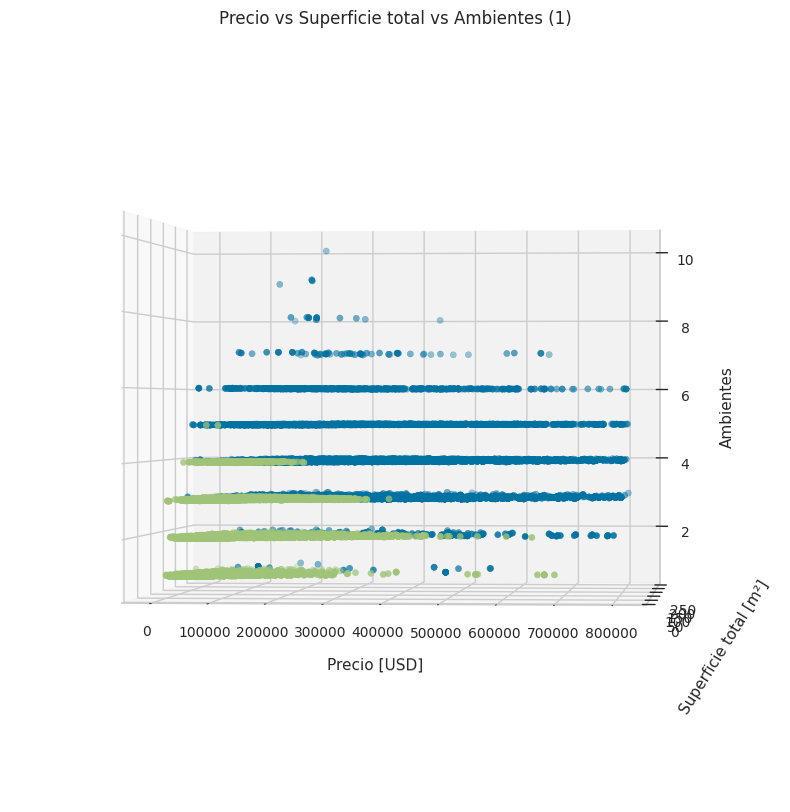

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.property_price, group1.property_surface_total, group1.property_rooms)
ax.scatter(group2.property_price, group2.property_surface_total, group2.property_rooms)
ax.set_xlabel("Precio [USD]", labelpad=20)
ax.set_ylabel("Superficie total [m²]", labelpad=20)
ax.set_zlabel("Ambientes", labelpad=20)
ax.elev = 0  
ax.azim = -85 
plt.title("Precio vs Superficie total vs Ambientes (1)")
plt.show()

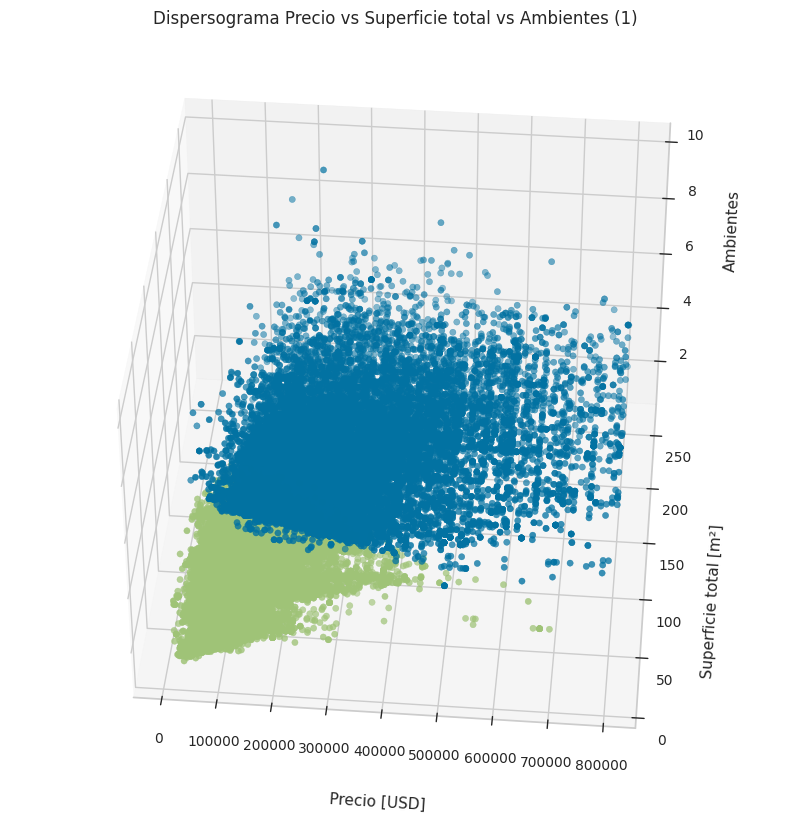

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.property_price, group1.property_surface_total, group1.property_rooms)
ax.scatter(group2.property_price, group2.property_surface_total, group2.property_rooms)
ax.set_xlabel("Precio [USD]", labelpad=20)
ax.set_ylabel("Superficie total [m²]", labelpad=20)
ax.set_zlabel("Ambientes", labelpad=20)
ax.elev = 40  
ax.azim = -85 
plt.title("Dispersograma Precio vs Superficie total vs Ambientes (1)")
plt.show()

### Conclusiones para 2 clusters

Teniendo en cuenta lo observado previamente en el mapa de CABA y todas las demás visualizaciones según ubicación, observamos que no parece existir mucha relacion entre la clusterización obtenida por el modelo contrastando features individuales con la localización geografica de las propiedades.

Lo unico que se puede llegar a observar es una relación entre la clusterización y el crecimiento de valores en el resto de variables que previamente se sabía que tenían correlación (esto se ve muy claramente en las comparaciones: Precio vs Superficie total vs Ambientes;  Prive vs Ambientes; Superficie total vs Rooms; Superficie total vs Superficie cubierta). 

Procedemos a reaplicar el modelo teniendo ahora un número de 3 clusters.

### Repeticion del proceso anterior aplicado a formación de 3 clusters

Comenzamos visualizando el grafico de silhouette para 3 grupos. Tener en cuenta que el calculo del score se hizo previamente, y si bien resultó ser peor que para 2 grupos proseguimos para observar como resultan los clusters.

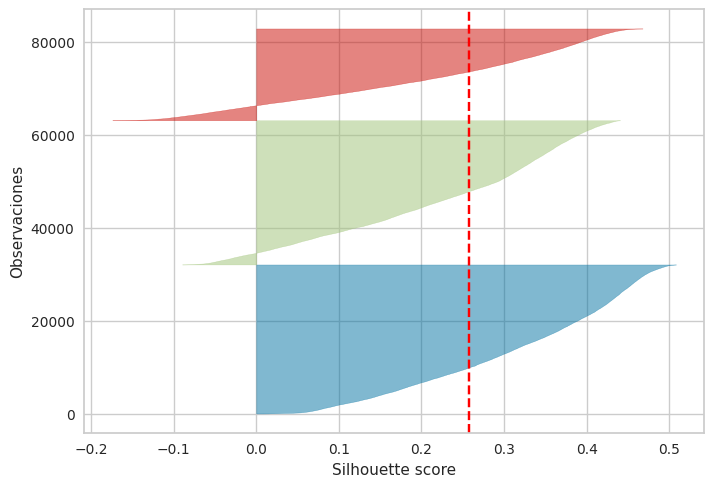

In [29]:
model = KMeans(3, random_state=0)

# Visualizamos el gráfico de silueta para 3 clusters
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(ds_properati_numeric_escalado)
plt.xlabel("Silhouette score")
plt.ylabel("Observaciones")
plt.show()

Ahora continuamos con la formación de clusters nuevos, sus visualizaciones y posteriormente su análisis.

In [30]:
kmeans = KMeans(n_clusters=3, random_state=0)  #Creamos un objeto de la clase KMeans para realizar el agrupamiento

kmeans.fit(ds_properati_numeric_escalado) #Entrenamos el algoritmo para que aprenda cómo agrupar

y_kmeans = kmeans.predict(ds_properati_numeric_escalado)

In [31]:
group1 = ds_properati_numeric[y_kmeans == 0]
group2 = ds_properati_numeric[y_kmeans == 1]
group3 = ds_properati_numeric[y_kmeans == 2]

In [32]:
group1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32073 entries, 0 to 82854
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   32073 non-null  float64
 1   longitud                  32073 non-null  float64
 2   property_rooms            32073 non-null  float64
 3   property_bedrooms         32073 non-null  float64
 4   property_surface_total    32073 non-null  float64
 5   property_surface_covered  32073 non-null  float64
 6   property_price            32073 non-null  float64
dtypes: float64(7)
memory usage: 2.0 MB


In [33]:
group2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31029 entries, 15 to 82853
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   31029 non-null  float64
 1   longitud                  31029 non-null  float64
 2   property_rooms            31029 non-null  float64
 3   property_bedrooms         31029 non-null  float64
 4   property_surface_total    31029 non-null  float64
 5   property_surface_covered  31029 non-null  float64
 6   property_price            31029 non-null  float64
dtypes: float64(7)
memory usage: 1.9 MB


In [34]:
group3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19753 entries, 2 to 82850
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   19753 non-null  float64
 1   longitud                  19753 non-null  float64
 2   property_rooms            19753 non-null  float64
 3   property_bedrooms         19753 non-null  float64
 4   property_surface_total    19753 non-null  float64
 5   property_surface_covered  19753 non-null  float64
 6   property_price            19753 non-null  float64
dtypes: float64(7)
memory usage: 1.2 MB


### Grafico geografico sobre los 3 clusters obtenidos

Se realiza una primera visualización de los grupos obtenidos sobre el mapa de CABA

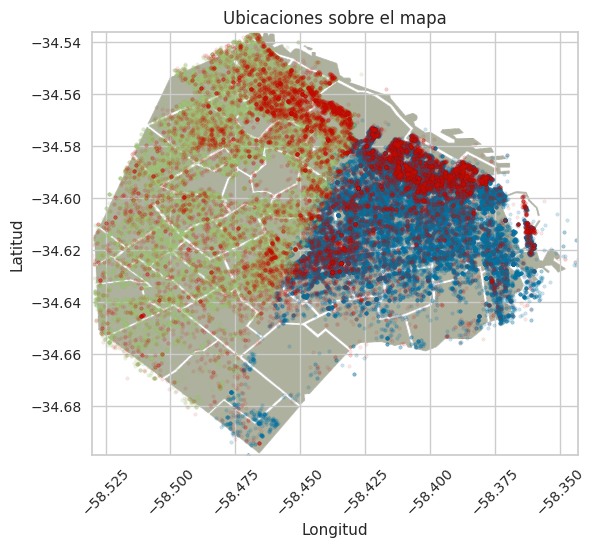

In [35]:
# calculamos limites de la imagen
lat_min = ds_properati_numeric['latitud'].min()
lat_max = ds_properati_numeric['latitud'].max()
long_min = ds_properati_numeric['longitud'].min()
long_max = ds_properati_numeric['longitud'].max()

# seteamos limites del grafico
plt.xlim([long_min, long_max])
plt.ylim([lat_min,lat_max])

# cargamos imagen y ajustamos su tamaño
im = plt.imread("mapa.png")
plt.imshow(im, extent=[long_min-0.0075, long_max+0.0025, lat_min, lat_max])

# graficamos los puntos
plt.scatter(x=group1.longitud,y=group1.latitud ,s=25 ,cmap='viridis', alpha=0.2, marker='.')
plt.scatter(x=group2.longitud,y=group2.latitud ,s=25 ,cmap='viridis', alpha=0.2, marker='.')
plt.scatter(x=group3.longitud,y=group3.latitud ,s=25 ,cmap='viridis', alpha=0.1, marker='.')

plt.title('Ubicaciones sobre el mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.tick_params(axis='x', labelrotation = 45)
plt.show()

### Analisis y visualizacion de los 3 clusters formados

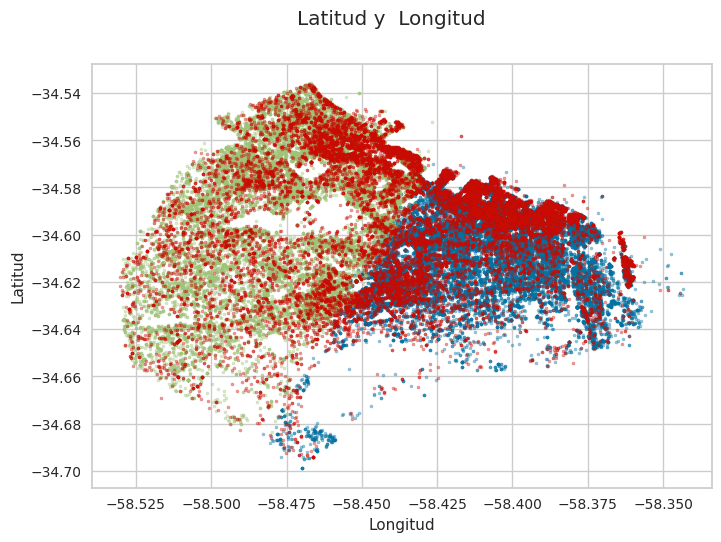

In [36]:
fig, ax = plt.subplots(1)
fig.suptitle('Latitud y  Longitud')

plt.scatter(x=group1.longitud, y=group1.latitud,s=5 ,cmap='viridis', alpha=0.4)
plt.scatter(x=group2.longitud, y=group2.latitud,s=5 ,cmap='viridis', alpha=0.4)
plt.scatter(x=group3.longitud, y=group3.latitud,s=5 ,cmap='viridis', alpha=0.4)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

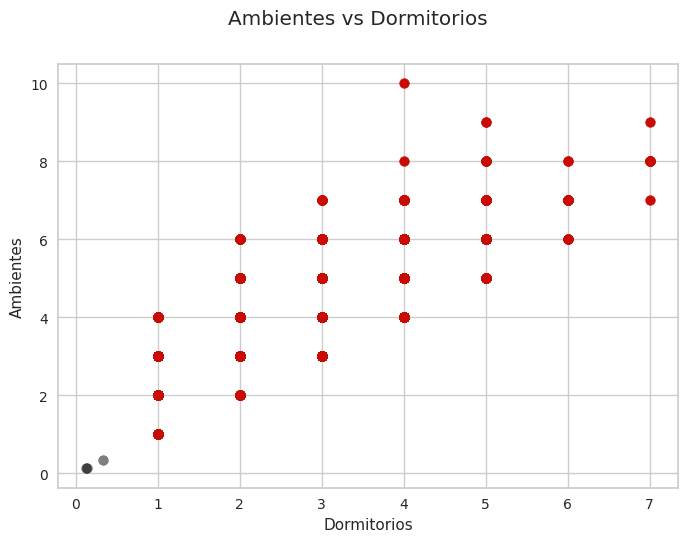

In [37]:
centers = kmeans.cluster_centers_
fig, ax = plt.subplots(1)
fig.suptitle('Ambientes vs Dormitorios')
plt.scatter(group1.property_bedrooms, group1.property_rooms,s=50 ,cmap='viridis')
plt.scatter(group2.property_bedrooms, group2.property_rooms,s=50 ,cmap='viridis')
plt.scatter(group3.property_bedrooms, group3.property_rooms,s=50 ,cmap='viridis')
plt.scatter(centers[:, 2], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel('Dormitorios')
plt.ylabel('Ambientes')
plt.show()

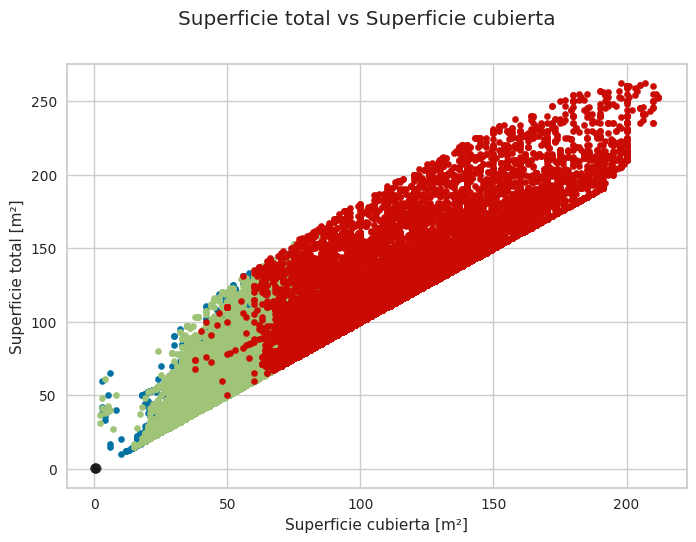

In [38]:
fig, ax = plt.subplots(1)
fig.suptitle('Superficie total vs Superficie cubierta')
plt.scatter(group1.property_surface_covered, group1.property_surface_total,s=20 ,cmap='viridis')
plt.scatter(group2.property_surface_covered, group2.property_surface_total,s=20 ,cmap='viridis')
plt.scatter(group3.property_surface_covered, group3.property_surface_total,s=20 ,cmap='viridis')
plt.scatter(centers[:, 4], centers[:, 4], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel('Superficie cubierta [m²]')
plt.ylabel('Superficie total [m²]')
plt.show()

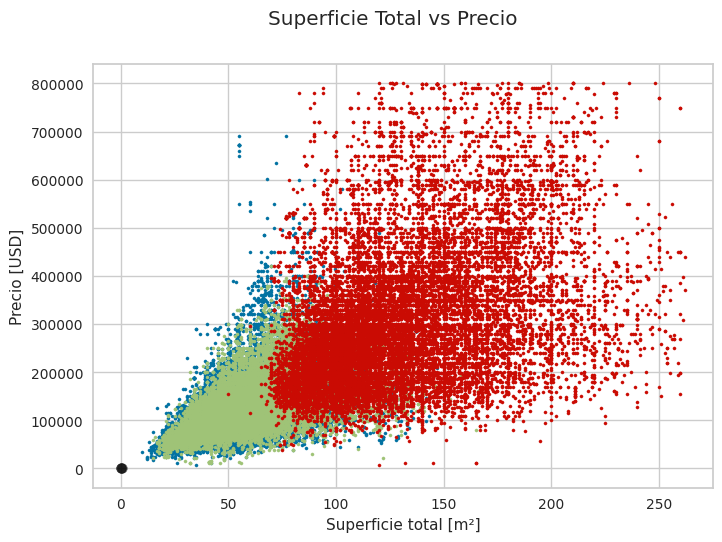

In [39]:
fig, ax = plt.subplots(1)
fig.suptitle('Superficie Total vs Precio')
plt.scatter(group1.property_surface_total, group1.property_price,s=5 ,cmap='viridis')
plt.scatter(group2.property_surface_total, group2.property_price,s=5 ,cmap='viridis')
plt.scatter(group3.property_surface_total, group3.property_price,s=5 ,cmap='viridis')
plt.scatter(centers[:, 4], centers[:, 4], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel('Superficie total [m²]')
plt.ylabel('Precio [USD]')
plt.show()

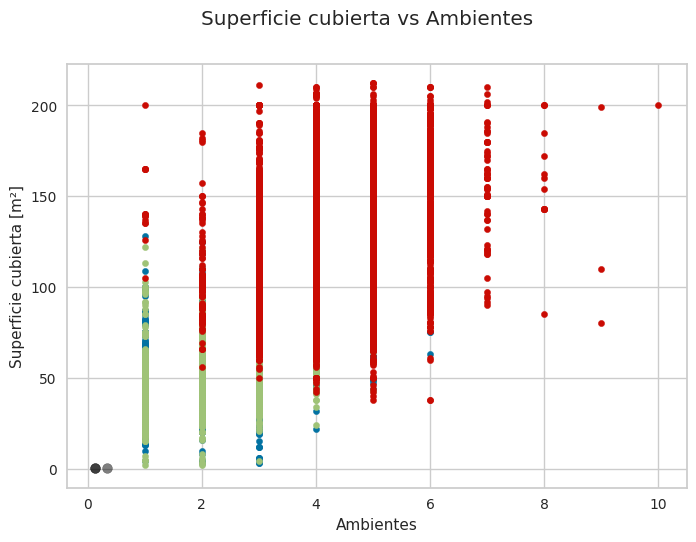

In [40]:
fig, ax = plt.subplots(1)
fig.suptitle('Superficie cubierta vs Ambientes')
plt.scatter(group1.property_rooms, group1.property_surface_covered,s=20 ,cmap='viridis')
plt.scatter(group2.property_rooms, group2.property_surface_covered,s=20 ,cmap='viridis')
plt.scatter(group3.property_rooms, group3.property_surface_covered,s=20 ,cmap='viridis')
plt.scatter(centers[:, 2], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel('Ambientes')
plt.ylabel('Superficie cubierta [m²]')
plt.show()

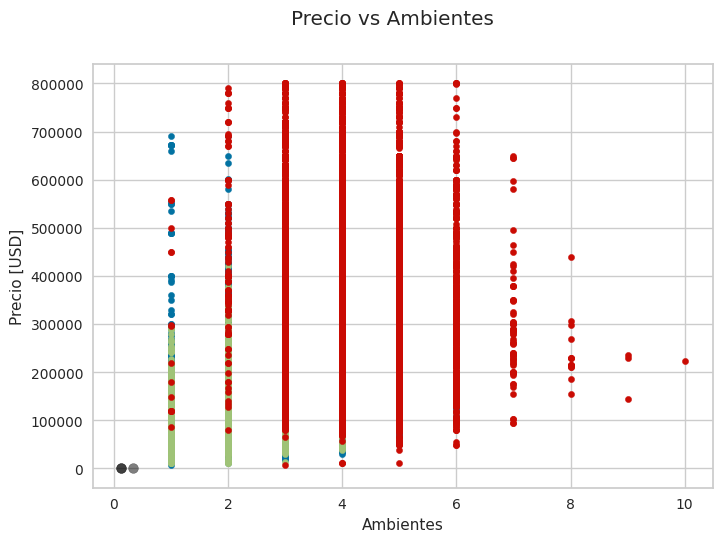

In [41]:
fig, ax = plt.subplots(1)
fig.suptitle('Precio vs Ambientes')
plt.scatter(group1.iloc[:, 2], group1.iloc[:, 6],s=20,cmap='viridis')
plt.scatter(group2.iloc[:, 2], group2.iloc[:, 6],s=20,cmap='viridis')
plt.scatter(group3.iloc[:, 2], group3.iloc[:, 6],s=20 ,cmap='viridis')
plt.scatter(centers[:, 2], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.xlabel('Ambientes')
plt.ylabel('Precio [USD]')
plt.show()

De la misma manera que el caso anterior (2 clusters) no se puede llegar a concluir mucha información solamente a partir de los graficos anteriores por la cantidad de variables utilizadas, sin embargo empezamos a tener una idea de que para esta clusterización puede que se haya tenido mucho más en cuenta la ubicación de las propiedades dada la visualización en el mapa.

Se procede ahora con un análisis del mismo tipo con graficos tridimensionales, teniendo en cuenta las mismas comparaciones de variables que con los clusters anteriores 
(Latitud vs Longitud vs Precio; Latitud vs Longitud vs Superficie total; Latitud vs Longitud vs Ambientes; Precio vs Superficie total vs Ambientes; Latitud vs Longitud vs PCA (de una unica componente))

- **Latitud vs Longitud vs Precio:**

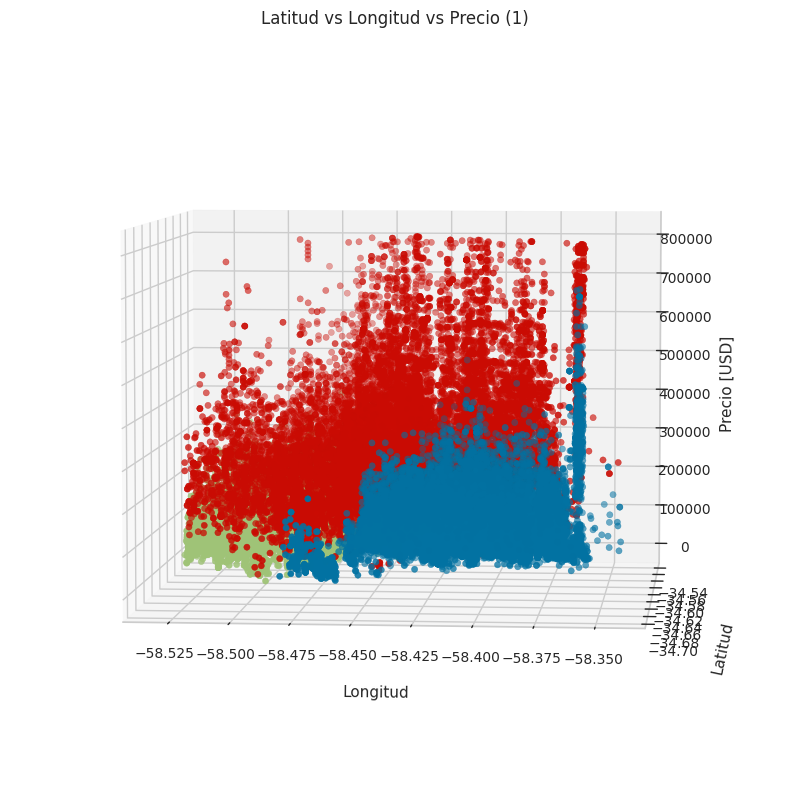

In [42]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_price)
ax.scatter(group2.longitud, group2.latitud,group2.property_price)
ax.scatter(group3.longitud, group3.latitud,group3.property_price)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Precio [USD]", labelpad=20)
ax.elev = 5  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Precio (1)")
plt.show()

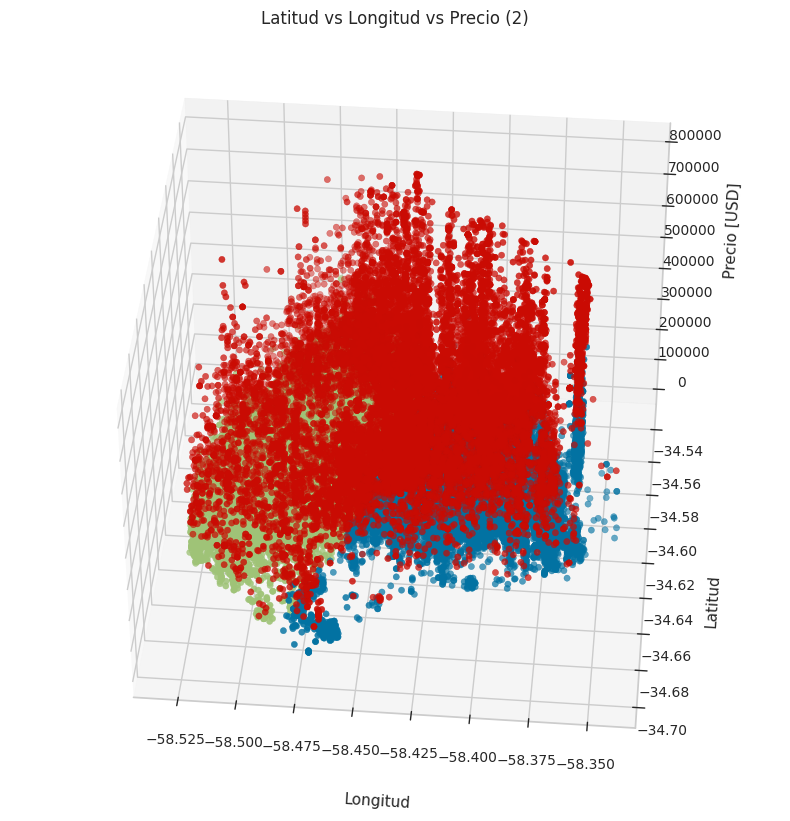

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_price)
ax.scatter(group2.longitud, group2.latitud,group2.property_price)
ax.scatter(group3.longitud, group3.latitud,group3.property_price)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Precio [USD]", labelpad=20)
ax.elev = 40  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Precio (2)")
plt.show()

- **Latitud vs Longitud vs Superficie total:**

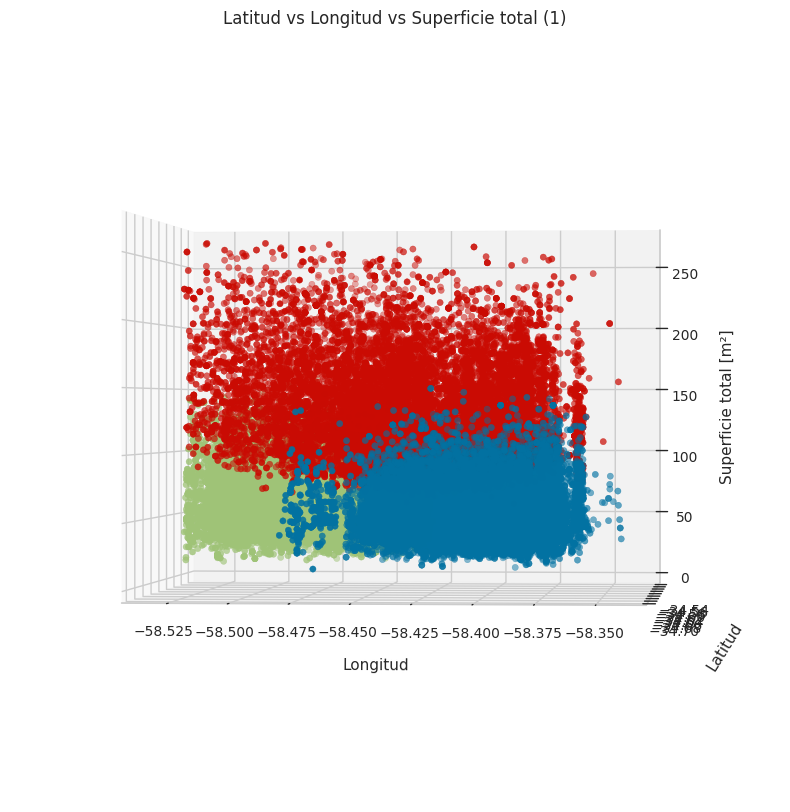

In [44]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_surface_total)
ax.scatter(group2.longitud, group2.latitud,group2.property_surface_total)
ax.scatter(group3.longitud, group3.latitud,group3.property_surface_total)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Superficie total [m²]", labelpad=20)
ax.elev = 0  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Superficie total (1)")
plt.show()

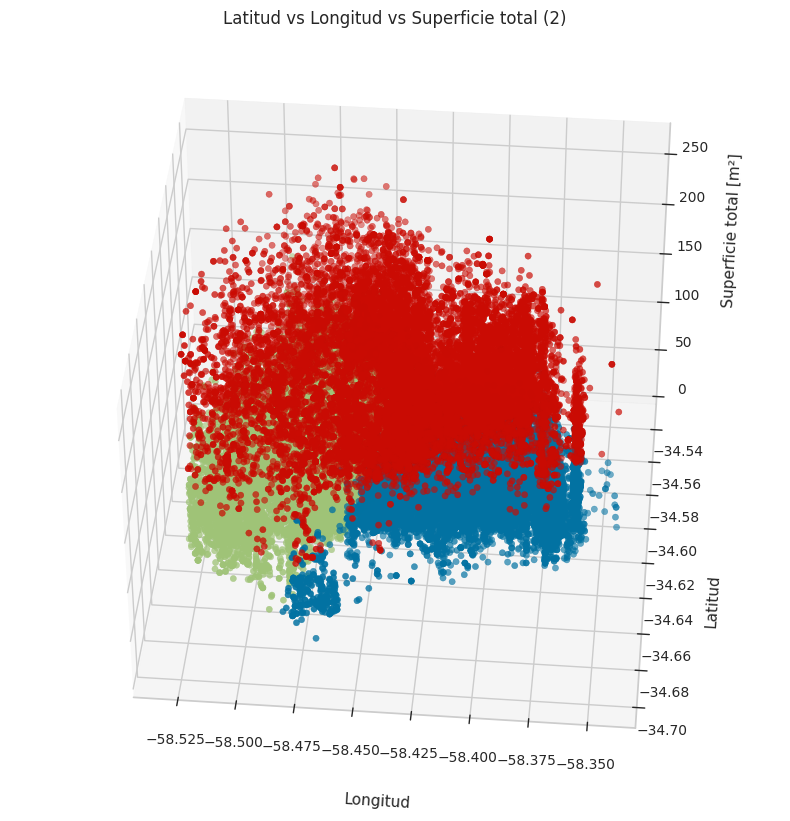

In [45]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_surface_total)
ax.scatter(group2.longitud, group2.latitud,group2.property_surface_total)
ax.scatter(group3.longitud, group3.latitud,group3.property_surface_total)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Superficie total [m²]", labelpad=20)
ax.elev = 40  
ax.azim = -85 
plt.title("Latitud vs Longitud vs Superficie total (2)")
plt.show()

- **Latitud vs Longitud vs Ambientes:**

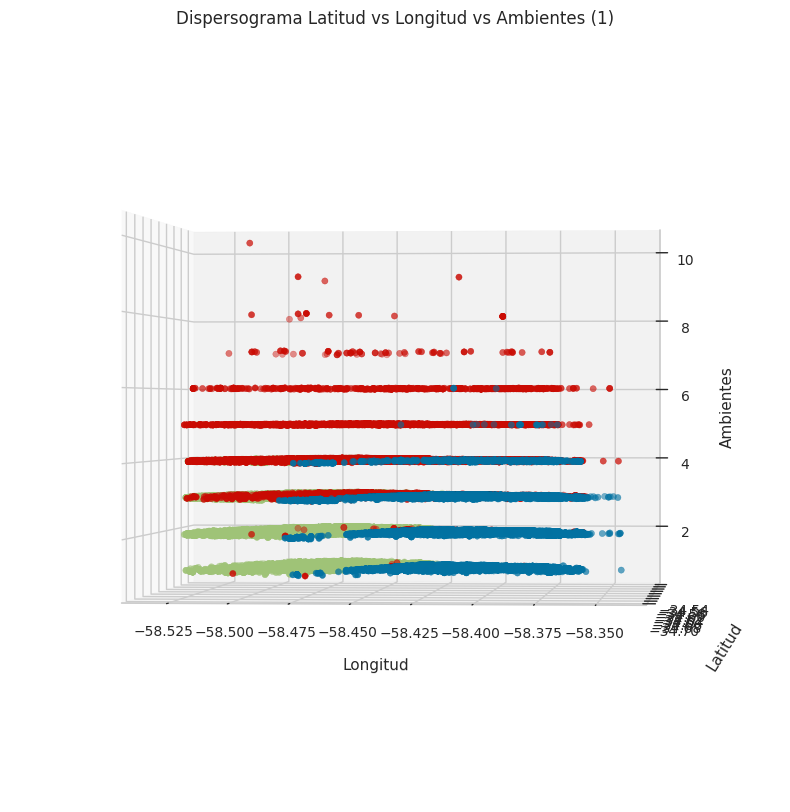

In [46]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_rooms)
ax.scatter(group2.longitud, group2.latitud,group2.property_rooms)
ax.scatter(group3.longitud, group3.latitud,group3.property_rooms)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Ambientes", labelpad=20)
ax.elev = 0  
ax.azim = -85 
plt.title("Dispersograma Latitud vs Longitud vs Ambientes (1)")
plt.show()

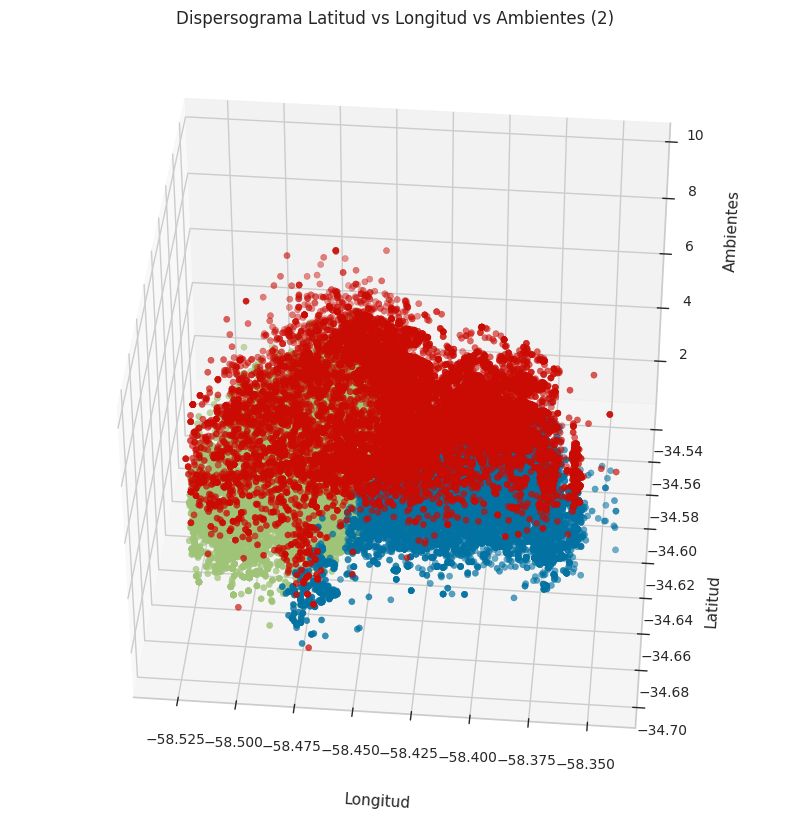

In [47]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.longitud, group1.latitud,group1.property_rooms)
ax.scatter(group2.longitud, group2.latitud,group2.property_rooms)
ax.scatter(group3.longitud, group3.latitud,group3.property_rooms)
ax.set_xlabel("Longitud", labelpad=20)
ax.set_ylabel("Latitud", labelpad=20)
ax.set_zlabel("Ambientes", labelpad=20)
ax.elev = 40  
ax.azim = -85 
plt.title("Dispersograma Latitud vs Longitud vs Ambientes (2)")
plt.show()

- **Precio vs Superficie total vs Ambientes:**

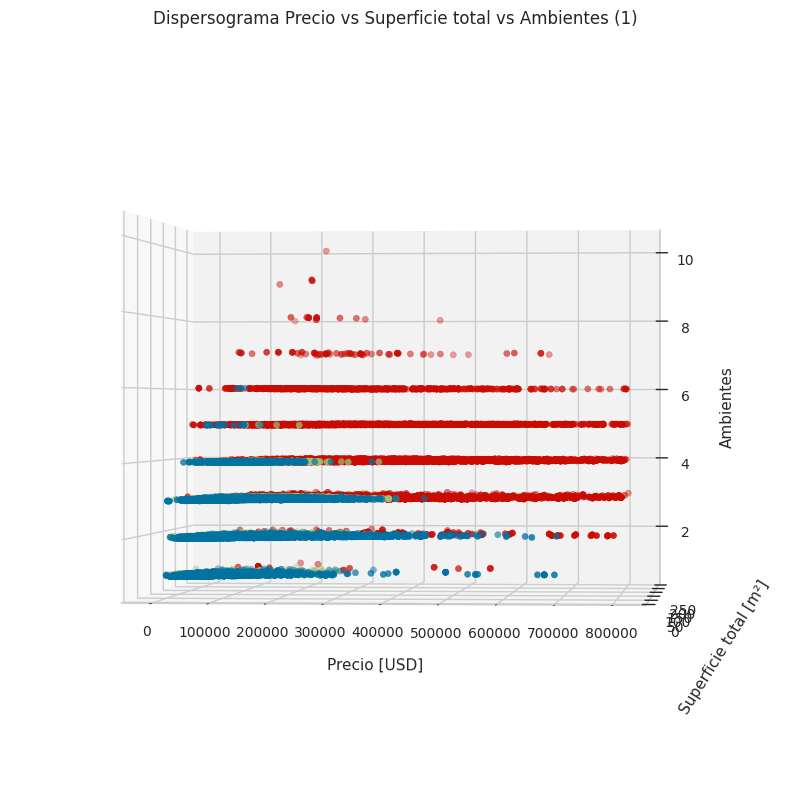

In [48]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.property_price, group1.property_surface_total, group1.property_rooms)
ax.scatter(group2.property_price, group2.property_surface_total, group2.property_rooms)
ax.scatter(group3.property_price, group3.property_surface_total, group3.property_rooms)
ax.set_xlabel("Precio [USD]", labelpad=20)
ax.set_ylabel("Superficie total [m²]", labelpad=20)
ax.set_zlabel("Ambientes", labelpad=20)
ax.elev = 0  
ax.azim = -85 
plt.title("Dispersograma Precio vs Superficie total vs Ambientes (1)")
plt.show()

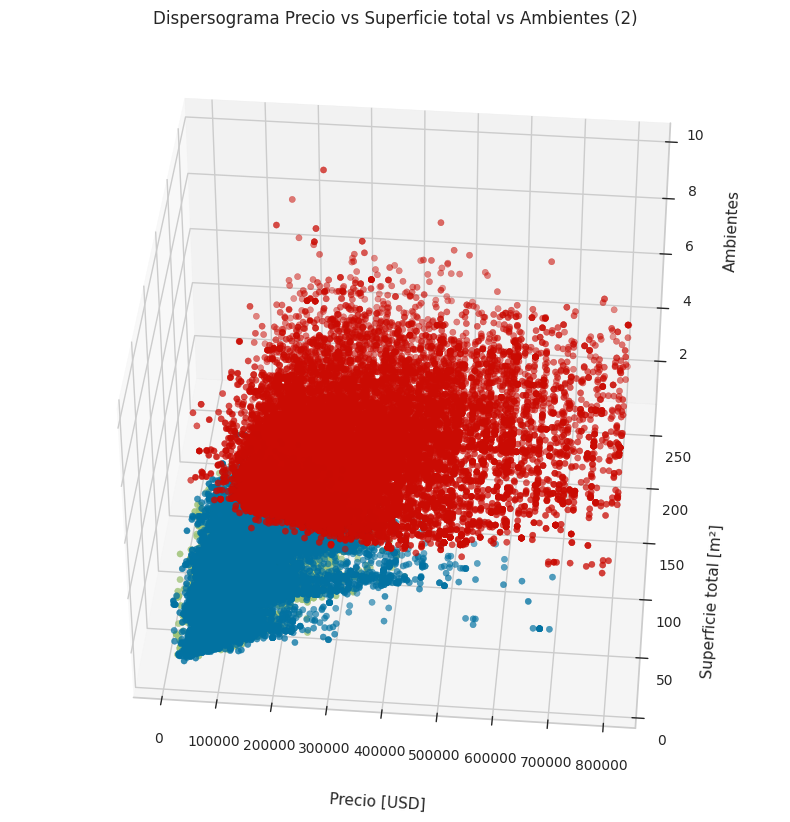

In [49]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(group1.property_price, group1.property_surface_total, group1.property_rooms)
ax.scatter(group2.property_price, group2.property_surface_total, group2.property_rooms)
ax.scatter(group3.property_price, group3.property_surface_total, group3.property_rooms)
ax.set_xlabel("Precio [USD]", labelpad=20)
ax.set_ylabel("Superficie total [m²]", labelpad=20)
ax.set_zlabel("Ambientes", labelpad=20)
ax.elev = 40
ax.azim = -85 
plt.title("Dispersograma Precio vs Superficie total vs Ambientes (2)")
plt.show()

### Conclusiones para 3 clusters

Teniendo en cuenta los graficos en perspectiva y el gráfico geográfico sobre CABA, podemos confirmar mejor las afirmaciones previas (a partir de los graficos en 2 dimensiones), dado que interpretamos que se observa una relacion entre todas las siguientes:
- Los grupos formados.
- La ubicación geografica de las propiedades.
- El crecimiento de valores en conjunto como el precio, la superficie y la cantidad de ambientes.

Principalmente destacamos la relación que no existía antes con la ubicación de las propiedades, la cual comparandolo con el resto de visualziaciones, denota una tendencia al crecimiento de los valores según se va de sur a norte y de occidente a oriente. Claramente además hay lugares que no tienen este mismo comportamiento marcado, pero es algo que posteriormente puede llegar a tener comparación con lo que se desarrolle en el punto 3 de este trabajo. 

---

## Continuación con sección Clasificación en notebook parte_3

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7da1cea6-caf2-4c30-b019-068f1fb82c77' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>